In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('../Clean_Data.csv', index_col=False)

In [4]:
df_CO2_Scaled = pd.read_csv('../Scaled_data.csv')

In [5]:
df = df.drop(columns=['Unnamed: 0'])

In [6]:
df.head()

,Year,Total,Coal,Oil,Gas,Flaring,Per Capita,Antarctica,Asia,Europe,North America,Oceania,South America
0,1950-01-01,0.084272,0.021068,0.063204,0.0,0.0,0.011266,0,1,0,0,0,0
1,1951-01-01,0.091600,0.025648,0.065952,0.0,0.0,0.012098,0,1,0,0,0,0
2,1952-01-01,0.091600,0.031708,0.059892,0.0,0.0,0.011946,0,1,0,0,0,0
3,1953-01-01,0.106256,0.037949,0.068307,0.0,0.0,0.013685,0,1,0,0,0,0
4,1954-01-01,0.106256,0.042502,0.063754,0.0,0.0,0.013511,0,1,0,0,0,0


In [7]:
df['Year']=df['Year'].astype(str)
df['Year']=[x[:4] for x in df['Year']]
df['Year']=pd.to_datetime(df['Year'], format='%Y')

In [8]:
year_total = df[['Year','Total']]
year_total.set_index('Year', inplace=True)
year_total.sort_index(inplace=True)
year_total.index = pd.DatetimeIndex(year_total.index).to_period('Y')

C:\Users\akhil\AppData\Local\Temp\ipykernel_22512\4241208767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_total.sort_index(inplace=True)


In [9]:
df_World = pd.read_csv('../df_World.csv')
df_World.set_index('Year', inplace=True)
df_World.sort_index(inplace=True)
df_World.index = pd.DatetimeIndex(df_World.index).to_period('Y')
df_World.index = df_World.index.to_timestamp()

In [10]:
df.dtypes

Year             datetime64[ns]
Total                   float64
Coal                    float64
Oil                     float64
Gas                     float64
Flaring                 float64
Per Capita              float64
Antarctica                int64
Asia                      int64
Europe                    int64
North America             int64
Oceania                   int64
South America             int64
dtype: object

In [11]:
year_total.head()

,Total
Year,
1820,3.381872
1820,2.901888
1820,0.333424
1820,42.528048
1820,0.791424


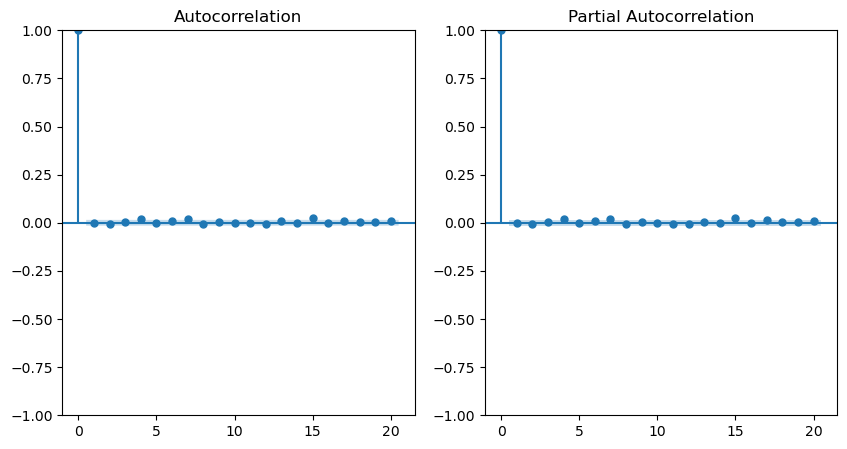

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(year_total, lags=20, alpha=0.05, ax=ax[0])
plot_pacf(year_total, lags=20, alpha=0.05, ax=ax[1])
plt.show()

In [13]:
df.set_index('Year', inplace=True)
df.sort_index(inplace=True)

In [14]:
df.index = pd.DatetimeIndex(df.index).to_period('Y')

In [15]:
X = df.drop(columns='Total')
y = df['Total']

In [16]:
tss = TimeSeriesSplit(n_splits = 5)

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in tss.split(df):
    train_data, test_data = df.Total.iloc[train_index], df.Total.iloc[test_index]

    model = ARIMA(train_data, order = (0,0,0))
    fitted_model = model.fit()

    y_pred = fitted_model.forecast(steps=len(test_data))

    mse = mean_squared_error(test_data, y_pred)
    mse_scores.append(mse)

    mae = mean_absolute_error(test_data, y_pred)
    mae_scores.append(mae)

    r2 = r2_score(test_data, y_pred)
    r2_scores.append(r2)
    
    print(f'Mean Squared Error for current split: {mse}', len(train_index))
    print(f'Mean Absolute Error for current split: {mae}', len(train_index))
    print(f'r squared for current split: {r2}', len(train_index))

Mean Squared Error for current split: 64203.774130229285 2821
Mean Absolute Error for current split: 97.82062700067047 2821
r squared for current split: -0.011071756120255127 2821
Mean Squared Error for current split: 142870.47131723602 5639
Mean Absolute Error for current split: 110.28077195552204 5639
r squared for current split: -0.0029827645083631005 5639
Mean Squared Error for current split: 184200.27385513214 8457
Mean Absolute Error for current split: 127.53109113579559 8457
r squared for current split: -0.005123645387641318 8457
Mean Squared Error for current split: 302422.62781259697 11275
Mean Absolute Error for current split: 149.65562667090396 11275
r squared for current split: -0.006196067763491575 11275
Mean Squared Error for current split: 633279.1146584868 14093
Mean Absolute Error for current split: 187.16072686155172 14093
r squared for current split: -0.007915148067880518 14093


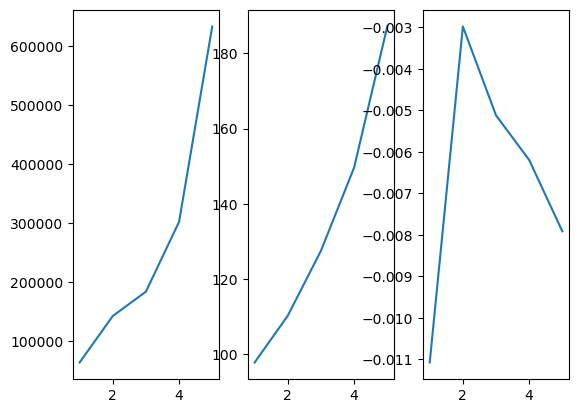

In [18]:
split = [1,2,3,4,5]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plot_mse = ax1.plot(split,mse_scores)
plot_mae = ax2.plot(split,mae_scores)
plot_r2 = ax3.plot(split,r2_scores)
plt.show()

In [19]:
ARIMA_model = auto_arima(df.Total,
                        start_p = 0,
                        start_q = 0,
                        test = 'adf',
                        max_p = 3, max_q = 3,
                        m=1,
                        d=None,
                        seasonal=False,
                        trace=True,
                        error_action = 'warn',
                        supress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=257582.208, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=257558.771, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=257560.193, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=257545.285, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=257521.478, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=13.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=8.84 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=256900.380, Time=1.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=256898.416, Time=0.96 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=256897.646, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=256895.669, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=256897.647, Time=1.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=256899.649, Time=4.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 32.555 seconds


In [20]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                16911
Model:                        SARIMAX   Log Likelihood             -128445.835
Date:                Tue, 23 Apr 2024   AIC                         256895.669
Time:                        07:53:08   BIC                         256911.141
Sample:                    12-31-1820   HQIC                        256900.772
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     98.1113      7.673     12.786      0.000      83.072     113.151
sigma2      2.316e+05    527.222    439.353      0.000    2.31e+05    2.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):          27015097.27
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               7.10   Skew:                            12.27
Prob(H) (two-sided):                  0.00   Kurtosis:                       197.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

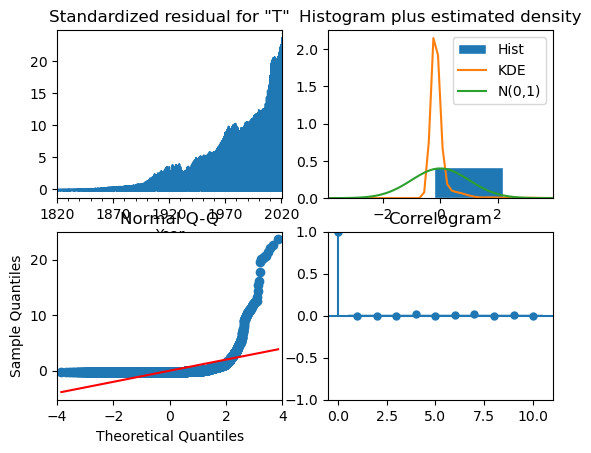

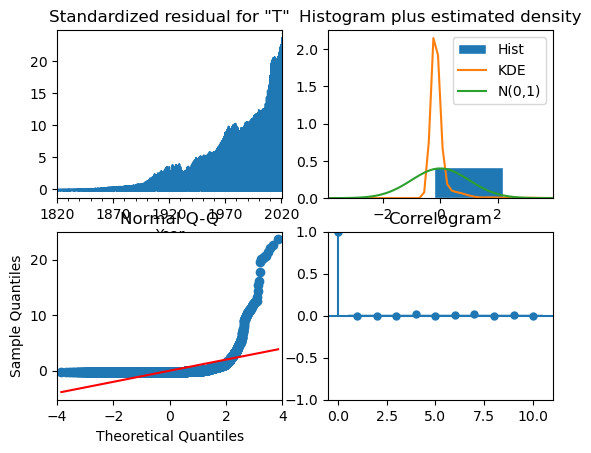

In [21]:
model = ARIMA(df.Total, order = (0,0,0))
model_fit = model.fit()
model_fit.plot_diagnostics()

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

index = df.index
columns = df.columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=columns, index=index)

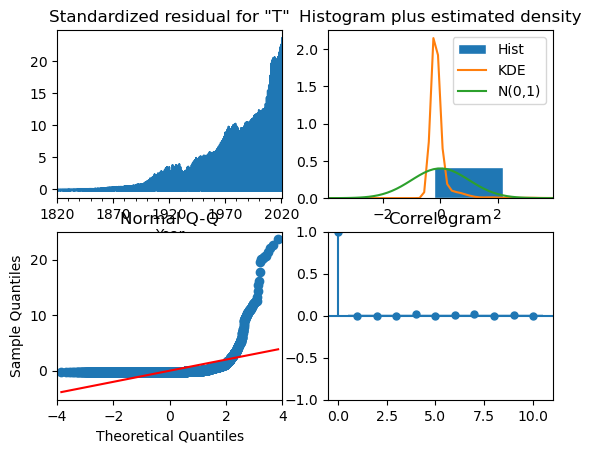

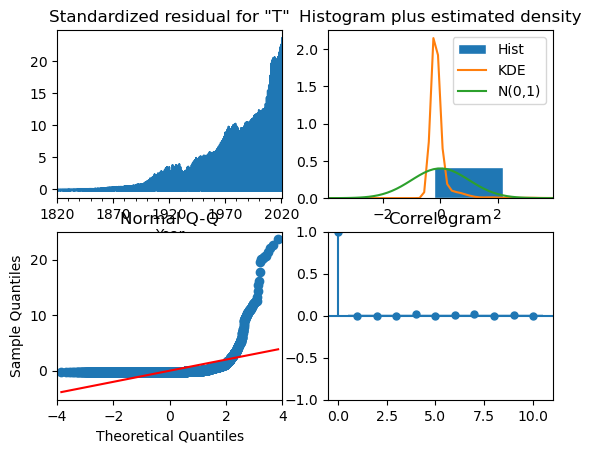

In [23]:
model = ARIMA(df_scaled.Total, order = (0,0,0))
model_fit = model.fit()
model_fit.plot_diagnostics()

In [24]:
import numpy as np
year_total.Total = np.log(year_total.Total)

C:\Users\akhil\AppData\Local\Temp\ipykernel_22512\2706236757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_total.Total = np.log(year_total.Total)


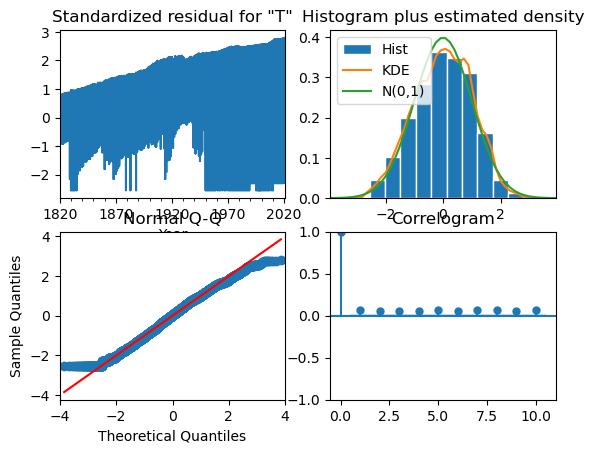

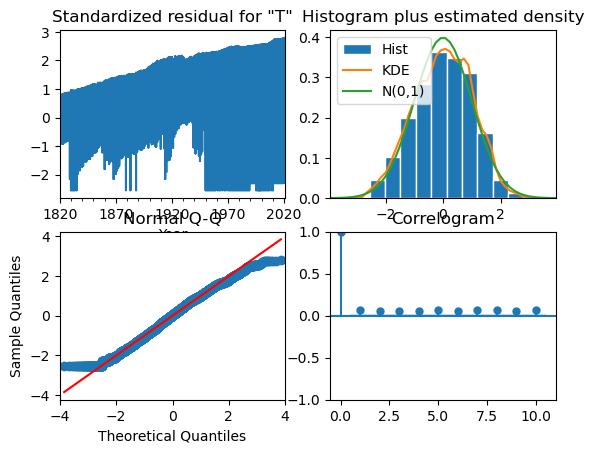

In [25]:
model = ARIMA(year_total.Total, order = (0,0,0))
model_fit = model.fit()
model_fit.plot_diagnostics()

In [26]:
output = pd.DataFrame(model_fit.forecast(steps = 300))

In [27]:
output.head()

,predicted_mean
18731,1.523085
18732,1.523085
18733,1.523085
18734,1.523085
18735,1.523085


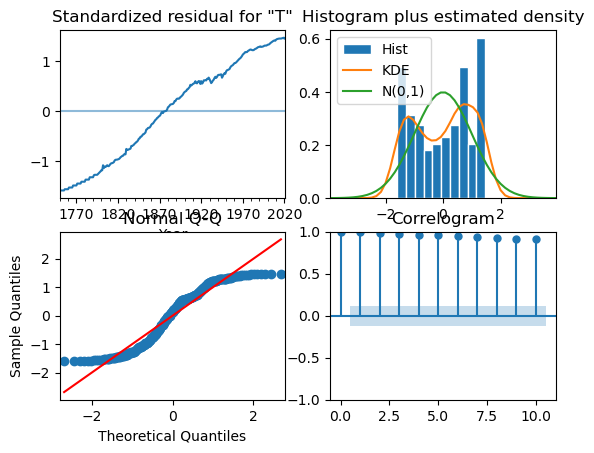

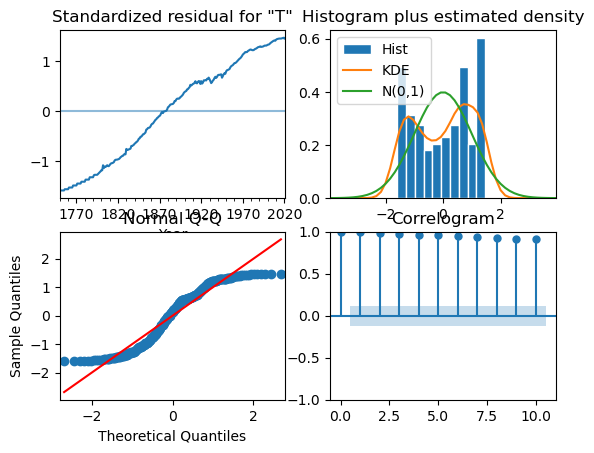

In [29]:
model = ARIMA(df_World.Total_log, order = (0,0,0))
model_fit = model.fit()
model_fit.plot_diagnostics()

In [30]:
ARIMA_model = auto_arima(df_World.Total_log,
                        start_p = 0,
                        start_q = 0,
                        test = 'adf',
                        max_p = 3, max_q = 3,
                        m=1,
                        d=None,
                        seasonal=False,
                        trace=True,
                        error_action = 'warn',
                        supress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-837.465, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-842.873, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-843.046, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-756.880, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-841.049, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-841.049, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-839.051, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-758.550, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.381 seconds


In [35]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  272
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 424.523
Date:                Tue, 23 Apr 2024   AIC                           -843.046
Time:                        07:59:40   BIC                           -832.239
Sample:                    01-01-1750   HQIC                          -838.707
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0306      0.003     11.787      0.000       0.026       0.036
ma.L1         -0.1677      0.044     -3.840      0.000      -0.253      -0.082
sigma2         0.0026      0.000     22.739      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               370.78
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.22
Prob(H) (two-sided):                  0.04   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

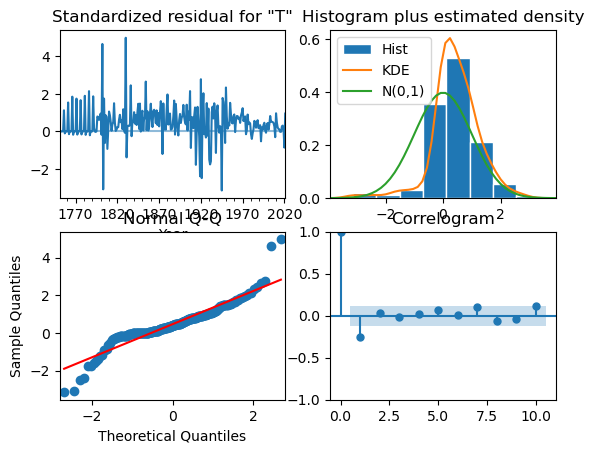

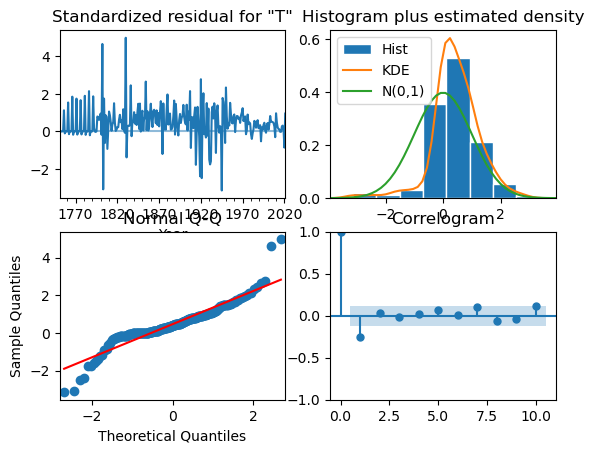

In [31]:
model = ARIMA(df_World.Total_log, order = (0,1,1))
model_fit = model.fit()
model_fit.plot_diagnostics()

In [33]:
tss = TimeSeriesSplit(n_splits = 5)

mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in tss.split(df_World):
    train_data, test_data = df_World.Total_log.iloc[train_index], df_World.Total_log.iloc[test_index]

    model = ARIMA(train_data, order = (0,1,1))
    fitted_model = model.fit()

    y_pred = fitted_model.forecast(steps=len(test_data))

    mse = mean_squared_error(test_data, y_pred)
    mse_scores.append(mse)

    mae = mean_absolute_error(test_data, y_pred)
    mae_scores.append(mae)

    r2 = r2_score(test_data, y_pred)
    r2_scores.append(r2)
    
    print(f'Mean Squared Error for current split: {mse}', len(train_index))
    print(f'Mean Absolute Error for current split: {mae}', len(train_index))
    print(f'r squared for current split: {r2}', len(train_index))

Mean Squared Error for current split: 0.8983222898015201 47
Mean Absolute Error for current split: 0.8298429626304706 47
r squared for current split: -3.284193359106114 47
Mean Squared Error for current split: 1.7393802665837026 92
Mean Absolute Error for current split: 1.1576181331510458 92
r squared for current split: -3.3560680749639014 92
Mean Squared Error for current split: 0.9294618116411931 137
Mean Absolute Error for current split: 0.8741289188481993 137
r squared for current split: -4.620823119741656 137
Mean Squared Error for current split: 0.8279896599593175 182
Mean Absolute Error for current split: 0.7614168377207606 182
r squared for current split: -2.2087568623993024 182
Mean Squared Error for current split: 0.1918001180373961 227
Mean Absolute Error for current split: 0.37125218524748554 227
r squared for current split: -2.553701107682373 227


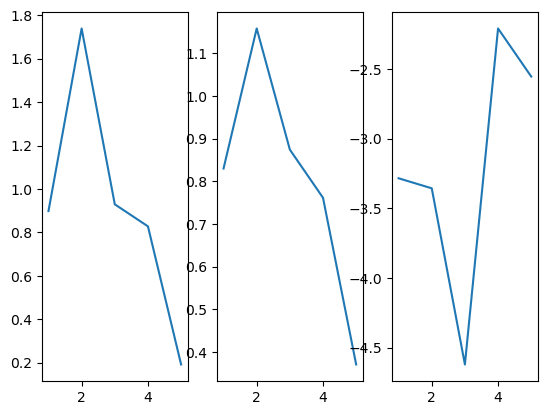

In [34]:
split = [1,2,3,4,5]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plot_mse = ax1.plot(split,mse_scores)
plot_mae = ax2.plot(split,mae_scores)
plot_r2 = ax3.plot(split,r2_scores)
plt.show()

In [ ]:
#forecasting